In [ ]:
!nvidia-smi

Tue Nov 17 11:12:32 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.38       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import os
import numpy as np
import tensorflow as tf
from PIL import Image
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

from glob import glob

## 이미지 불러오기

In [ ]:
# 이미지 경로 glob로 가져오기
img_paths = '/content/drive/Shareddrives/GOFOODA/data/test_image/*_*/*'
test_img_paths = glob(img_paths)
test_img_paths[:3], len(test_img_paths)

(['/content/drive/Shareddrives/GOFOODA/data/test_image/갈비구이_0/Screenshot from 2020-11-13 17-07-39.png',
  '/content/drive/Shareddrives/GOFOODA/data/test_image/갈비구이_0/Screenshot from 2020-11-13 17-07-57.png',
  '/content/drive/Shareddrives/GOFOODA/data/test_image/갈비구이_0/Screenshot from 2020-11-13 16-36-23.png'],
 112)

In [ ]:
# 이미지 읽어들이기, 라벨 값 리턴
def load_image(path, IMG_SIZE) :
    img = tf.io.read_file(path)
    img = tf.image.decode_image(img, channels=3, expand_animations=False)
    img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE))

    label = int(path.split('/')[-2].split('_')[-1])
    return img, label

0


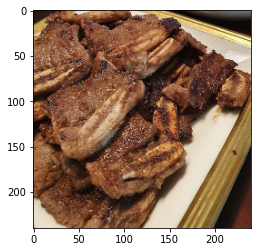

In [ ]:
cccc, llll = load_image(test_img_paths[0], 240)
print(llll)
plt.imshow(np.int32(cccc))
plt.show()

## 저장해둔 모델 가져오기

#### 먼저 모델들이 저장되어있는 경로들을 ```models_dirs```에 담는다

In [ ]:
models_dir = '/content/drive/Shareddrives/GOFOODA/data/models'
models_dirs = glob(os.path.join(models_dir, '*'))
models_dirs

['/content/drive/Shareddrives/GOFOODA/data/models/NASNetMobile_checkpoint',
 '/content/drive/Shareddrives/GOFOODA/data/models/MobileNet_checkpoint',
 '/content/drive/Shareddrives/GOFOODA/data/models/MobileNetV2_checkpoint',
 '/content/drive/Shareddrives/GOFOODA/data/models/DenseNet121_checkpoint',
 '/content/drive/Shareddrives/GOFOODA/data/models/EfficientNetB0_checkpoint',
 '/content/drive/Shareddrives/GOFOODA/data/models/EfficientNetB1_checkpoint',
 '/content/drive/Shareddrives/GOFOODA/data/models/Xception_checkpoint',
 '/content/drive/Shareddrives/GOFOODA/data/models/ResNet50_checkpoint']

#### 학습시킨 모델들에 대한 리스트(```model_lst```)를 생성, 이후에 선택해서 사용할 수 있게끔 활용

In [ ]:
model_lst = os.listdir(models_dir)
model_lst = [x for x in model_lst if 'ipynb' not in x]
model_lst = list(map(lambda x : x.split('/')[-1].split('_')[0], model_lst))
model_lst

['NASNetMobile',
 'MobileNet',
 'MobileNetV2',
 'DenseNet121',
 'EfficientNetB0',
 'EfficientNetB1',
 'Xception',
 'ResNet50']

In [ ]:
models = {}
for idx, m in enumerate(model_lst) :
    models[idx] = m

models

{0: 'NASNetMobile',
 1: 'MobileNet',
 2: 'MobileNetV2',
 3: 'DenseNet121',
 4: 'EfficientNetB0',
 5: 'EfficientNetB1',
 6: 'Xception',
 7: 'ResNet50'}

In [ ]:
def load_model() :
    global models_dirs
    global models

    print(f'사용가능한 모델\n{models}')
    model_num = int(input('사용할 모델의 번호 입력 : '))
    model_name = models[model_num]

    for models_dir in models_dirs:
        if model_name in models_dir :
            target = models_dir
    
    trained_models = glob(os.path.join(target, '*.h5'))
    trained_models = sorted(trained_models, key=lambda x : os.path.basename(x).split('-')[-1], reverse=True)  # 정확도 기준, 내림차순 정렬
    print('Model 불러오는 중...')
    target_model = tf.keras.models.load_model(trained_models[0]) # 가장 정확도가 높은 모델을 load
    print(f'불러온 모델의 경로 : {trained_models[0]}')
    print('완료\n')

    return target_model

In [ ]:
model = load_model()
model.summary()

사용가능한 모델
{0: 'NASNetMobile', 1: 'MobileNet', 2: 'MobileNetV2', 3: 'DenseNet121', 4: 'EfficientNetB0', 5: 'EfficientNetB1', 6: 'Xception', 7: 'ResNet50'}
사용할 모델의 번호 입력 : 5
Model 불러오는 중...
불러온 모델의 경로 : /content/drive/Shareddrives/GOFOODA/data/models/EfficientNetB1_checkpoint/10-0.06-0.98.h5
완료

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb0 (Functional)  (None, 7, 7, 1280)        4049571   
_________________________________________________________________
flatten (Flatten)            (None, 62720)             0         
_________________________________________________________________
dense (Dense)                (None, 512)               32113152  
_________________________________________________________________
dense_1 (Dense)              (None, 30)                15390     
Total params: 36,178,113
Trainable params: 36,136,090
Non-trainable params: 42,023
_________

## Test

In [ ]:
label_dict = {}
classes = os.listdir('/content/drive/Shareddrives/GOFOODA/data/food30')
classes.sort()
for idx, cla in enumerate(classes) :
    label_dict[idx] = cla
label_dict

{0: '갈비구이',
 1: '갈비탕',
 2: '갈치구이',
 3: '갈치조림',
 4: '감자탕',
 5: '계란말이',
 6: '고추튀김',
 7: '곰탕_설렁탕',
 8: '곱창전골',
 9: '김밥',
 10: '김치볶음밥',
 11: '김치전',
 12: '김치찌개',
 13: '닭볶음탕',
 14: '된장찌개',
 15: '만두',
 16: '비빔밥',
 17: '삼겹살',
 18: '새우볶음밥',
 19: '생선전',
 20: '소세지볶음',
 21: '양념치킨',
 22: '육개장',
 23: '육회',
 24: '제육볶음',
 25: '짬뽕',
 26: '찜닭',
 27: '파전',
 28: '피자',
 29: '후라이드치킨'}

In [ ]:
def visualize(pred, label, img) :
    global label_dict
    if pred == label :
        result = '일치'
    else :
        result = '불일치'

    print(f'예측 : {label_dict[pred]}, 정답 : {label_dict[label]}')
    print(result)
    img = np.squeeze(img)
    plt.imshow(np.int32(img))
    plt.show()

In [ ]:
def predict_test(model, img_paths, is_visual=False, is_choice=False) :
    
    IMG_SIZE = input("resize할 이미지의 사이즈를 입력하시오 : ")

    if IMG_SIZE == '' : 
        IMG_SIZE = 224
        print('Setting Default IMG_SIZE(224)')
    else:
        IMG_SIZE = int(IMG_SIZE)

    logits = []
    correct = 0

    if is_choice :
        num = int(input("Test에 사용할 이미지 개수 입력 : "))
        img_paths = np.random.choice(img_paths, num, replace=False)

    flag = True
    for img_path in tqdm(img_paths):
        img, label = load_image(img_path, IMG_SIZE)
        img = img[np.newaxis, :, :]
        pred = int(np.argmax(model.predict(img)))
        
        if is_visual and is_choice :
            visualize(pred, label, img)
        elif flag :
            print("시각화를 위해서는 is_visual과 is_choice를 둘 다 사용해 주세요.")
            flag = False
            
        if pred == label :
            correct += 1
        logits.append(pred)

    print(f'정확도 : {round(correct / len(img_paths), 4) * 100}%')
        

In [ ]:
predict_test(model, test_img_paths)

resize할 이미지의 사이즈를 입력하시오 : 
Setting Default IMG_SIZE(224)


시각화를 위해서는 is_visual과 is_choice를 둘 다 사용해 주세요.

정확도 : 87.5%


In [ ]:
predict_test(model, test_img_paths, is_visual=True)

resize할 이미지의 사이즈를 입력하시오 : 
Setting Default IMG_SIZE(224)


시각화를 위해서는 is_visual과 is_choice를 둘 다 사용해 주세요.

정확도 : 87.5%


resize할 이미지의 사이즈를 입력하시오 : 
Setting Default IMG_SIZE(224)
Test에 사용할 이미지 개수 입력 : 10


예측 : 감자탕, 정답 : 감자탕
일치


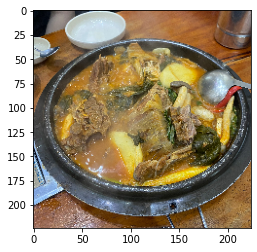

예측 : 감자탕, 정답 : 감자탕
일치


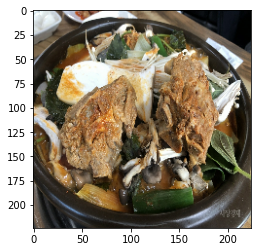

예측 : 갈치구이, 정답 : 갈치구이
일치


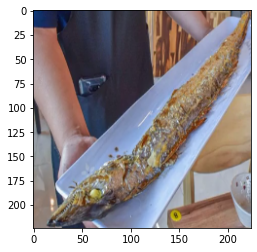

예측 : 감자탕, 정답 : 감자탕
일치


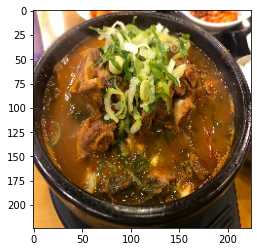

예측 : 육개장, 정답 : 김치볶음밥
불일치


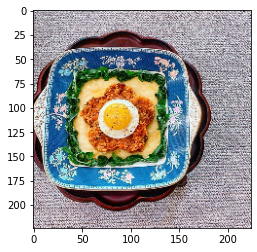

예측 : 삼겹살, 정답 : 삼겹살
일치


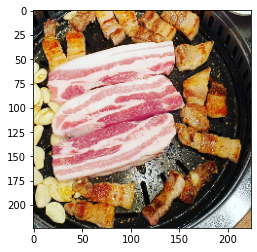

예측 : 감자탕, 정답 : 감자탕
일치


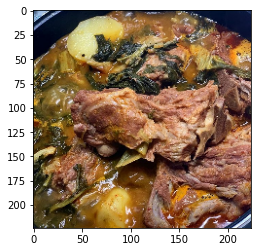

예측 : 찜닭, 정답 : 찜닭
일치


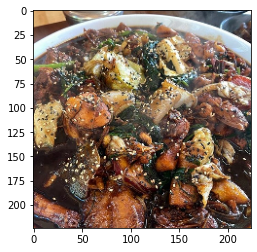

예측 : 찜닭, 정답 : 찜닭
일치


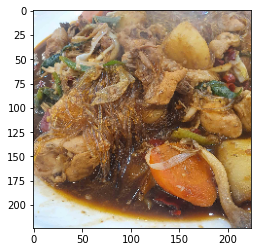

예측 : 찜닭, 정답 : 감자탕
불일치


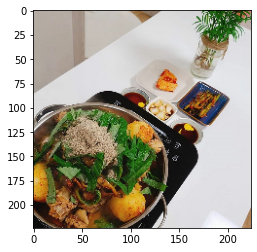


정확도 : 80.0%


In [ ]:
predict_test(model, test_img_paths, is_visual=True, is_choice=True)
